In [1]:
#dl.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#24 January 2018

In [2]:
#import matplotlib pandas etc
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from matplotlib import rcParams
sns.set(font_scale=1.5, font='DejaVu Sans')
pd.set_option('display.max_columns', None)
pd.set_option('display.height', None)
pd.set_option('display.width', None)
import time
time_start = time.time()

height has been deprecated.



In [3]:
#read 'chunks' dataframe; each record contains a random 100-word-long chunk of text from one of 89
#books from the gutenberg project
import pickle
with open('chunks.pkl', 'rb') as fp:
    chunks = pickle.load(fp)
print 'number of records = ', len(chunks)
print 'number of books = ', len(chunks['input_file'].unique())
chunks.head()

number of records =  125271
number of books =  88


,author,author_id,title,input_file,text_chunk
117538,Jules Verne,48,The Mysterious Island,iso/etext98/milnd11.txt,it was fed from some hidden source. The differ...
83826,Bram Stoker,9,Dracula,iso/etext95/dracu12.txt,that in saying this I am doing what my dear on...
82201,Laura S. Haviland,51,A Woman'S Life-Work,iso/etext05/wlwrk10.txt,in great excitement and asked her if she wante...
99610,William Makepeace Thackeray,86,Vanity Fair,iso/etext96/vfair12.txt,little heart beating with joy? Her letters hom...
2696,Dana,17,Two Years Before The Mast,iso/etext00/2yb4m10.txt,leg and said he had the scurvy; another had cu...


In [4]:
#show titles and number of chunks
N = pd.DataFrame(chunks.groupby(['author', 'title', 'input_file'])['text_chunk'].count()).reset_index()\
    .sort_values('author')
N = N.rename(columns={'text_chunk':'N_chunks'})
N.head()

,author,title,input_file,N_chunks
0,A.H. Clough,Plutarch's Lives,iso/etext96/plivs10.txt,2200
1,Adam Smith,Wealth Of Nations,iso/etext02/wltnt10.txt,2200
2,Adams,The Education Of Henry Adams,iso/etext00/eduha10.txt,1260
3,Anne C. Lynch Botta,Handbook Of Universal Literature,iso/etext05/8unlt10.txt,1699
4,Anthony Trollope,The Last Chronicle Of Barset,iso/etext02/lacob11.txt,2200


In [5]:
##select 10 books
#records = pd.DataFrame()
#old_ids = [11, 78, 81, 8, 10, 20, 30, 40, 50, 70]
#old_ids = [11, 78, 81, 8, 10, 20, 30, 40, 50, 70, 5, 15, 25, 35, 45, 55, 65, 75, 85, 88]
#for new_id in range(len(old_ids)):
#    idx = chunks['author_id'] == old_ids[new_id]
#    df = chunks[idx].copy()
#    records = records.append(df, ignore_index=True)
#records = records.sample(frac=1.0)
#print records['title'].unique()
#print 'number of records = ', len(records)
#records.head(20)

In [6]:
#train-test-validate split
train_size = 0.33
validate_size=0.5   #this is the fraction of the test sample that is assigned to the validation sample
rn_seed = 12
from sklearn.model_selection import train_test_split
train, test = train_test_split(chunks, train_size=train_size, random_state=rn_seed)
validate, test = train_test_split(test, train_size=validate_size, random_state=rn_seed)
print 'records.shape  = ', chunks.shape
print 'train.shape    = ', train.shape
print 'test.shape     = ', test.shape
print 'validate.shape = ', validate.shape

records.shape  =  (125271, 5)
train.shape    =  (41339, 5)
test.shape     =  (41966, 5)
validate.shape =  (41966, 5)


In [7]:
#confirm that all 88 books have records in the training sample
print len(train['input_file'].unique()), len(chunks['input_file'].unique())

88 88


In [8]:
#count number of distinct workds in training data...88 books have 241K words while Spanish book adds 12K words
from collections import defaultdict
word_frequency = defaultdict(int)
corpus = train['text_chunk'].tolist()
for doc in corpus:
    words = doc.split(' ')
    for word in words:
        word_frequency[word] += 1
print 'number of distinct words = ', len(word_frequency.keys()) 
for word in word_frequency.keys()[1:7]:
    print word, word_frequency[word]

number of distinct words =  241432
considered, 25
ready!' 4
considered. 12
vertebr�, 1
ready!" 1
nunnery 1


In [9]:
#generate tokenizer
vocabulary_size = 241432
N_inputs = 100
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(corpus)

Using TensorFlow backend.


In [10]:
#this helper function extracts and tokenizes x, and extracts y and onehot-encodes it
from keras.utils import np_utils
def tokenize(df, tokenizer):
    corpus = df['text_chunk'].tolist()
    corpus_tokenized = tokenizer.texts_to_sequences(corpus)
    corpus_padded = pad_sequences(corpus_tokenized, maxlen=N_inputs)
    x = np.array(corpus_padded)
    y_ids = df['author_id'].values
    y = np_utils.to_categorical(y_ids)
    return x, y

In [11]:
#get training x,y with x-values being tokenized and y values onehot-encoded
x_train, y_train = tokenize(train, tokenizer)
N_inputs = x_train.shape[1]
N_outputs = y_train.shape[1]
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
print 'N_inputs = ', N_inputs
print 'N_outputs = ', N_outputs
print 'vocabulary_size = ', vocabulary_size, x_train.min(), x_train.max()

x_train.shape =  (41339, 100)
y_train.shape =  (41339, 88)
N_inputs =  100
N_outputs =  88
vocabulary_size =  241432 0 94713


In [12]:
#display a training record
idx = 121
print train.iloc[idx]
text_chunk = train.iloc[idx]['text_chunk']
print text_chunk
print x_train[idx]
print y_train[idx]

author                                     John Mcelroy, Entire
author_id                                                    46
title                                             Andersonville
input_file                              iso/etext02/andvl11.txt
text_chunk    his approaching fate. Among other things he sa...
Name: 18351, dtype: object
his approaching fate. Among other things he said to his guard, as he washed himself elaborately the night before the day announced for the execution: "Well, you can be sure of one thing; to-morrow night there will certainly be one clean corpse on this Island." Unfortunately for his braggadocio, he let it leak out in some way that he had been well aware all the time that he would not be executed. He was taken to Fort Delaware for confinement, and died there some time after. Frank Beverstock went back to his regiment, and served with it until the close 
[ 2415  1093   210    66   190     8    40     4    11  1015    14     8
  3129   103 17364    

In [13]:
#show that the vectorized text preserves word order with punctuation dropped
tokens = []
words_marked = text_chunk.split(' ')[0:8]
words = [word.lower().strip(',').strip('.').strip('"').strip('?') for word in words_marked]
tokens = [tokenizer.word_index[word] for word in words]
print words
print tokens

['his', 'approaching', 'fate', 'among', 'other', 'things', 'he', 'said']
[11, 2415, 1093, 210, 66, 190, 8, 40]


In [14]:
#get validation x,y with x-values being tokenized and y values onehot-encoded
x_valid, y_valid = tokenize(validate, tokenizer)
print 'x_valid.shape = ', x_valid.shape
print 'y_valid.shape = ', y_valid.shape

x_valid.shape =  (41966, 100)
y_valid.shape =  (41966, 88)


In [15]:
#display a validation record
idx = 123
print validate.iloc[idx]
print validate.iloc[idx]['text_chunk']
print x_valid[321]
print y_valid[321]

author                                      Anne C. Lynch Botta
author_id                                                     3
title                          Handbook Of Universal Literature
input_file                              iso/etext05/8unlt10.txt
text_chunk    the peculiar growth of Athens. The whole struc...
Name: 78200, dtype: object
the peculiar growth of Athens. The whole structure of the theatre, as well as the drama itself, may be traced to the chorus, whose station was the original centre of the whole performance. The orchestra, which occupied a circular level space in the centre of the building, grew out of the chorus or dancing-place of the Homeric times. The altar of Bacchus, around which the dithyrambic chorus danced in a circle, had given rise to a sort of raised platform in the centre of the orchestra, which served as a resting-place for the chorus. The chorus sang alone when the 
[    0     0   207 11316    14     5   311     3  2102    51    36   453
 11316  682

In [16]:
#this LSTM model was adapted from 
#http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from keras.models import Sequential
def build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size, dropout_fraction):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=N_inputs))
    conv_layer_size = embedding_vector_length/2
    model.add(Conv1D(conv_layer_size, conv_kernel_size, activation='relu'))
    model.add(Dropout(dropout_fraction))
    pool_size = int(conv_kernel_size/2)
    model.add(MaxPooling1D(pool_size=pool_size))
    lstm_size = int(embedding_vector_length/2)
    model.add(LSTM(lstm_size, activation='tanh')) #try linear, tanh, relu
    model.add(Dropout(dropout_fraction))
    model.add(Dense(N_outputs, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
#assemble lstm model
N_training_epochs = 10
batch_size = 350
embedding_vector_length = 400
conv_kernel_size = 50
dropout_fraction = 0.67
rn_seed = 16
print 'N_training_epochs = ', N_training_epochs
print 'batch_size = ', batch_size
print 'number of training + validation samples = ', x_train.shape[0] + x_valid.shape[0]
print 'vocabulary_size = ', vocabulary_size
print 'embedding_vector_length = ', embedding_vector_length
print 'conv_kernel_size = ', conv_kernel_size
print 'dropout_fraction = ', dropout_fraction
print 'N_inputs = ', N_inputs, x_train.shape[1]
print 'N_outputs = ', N_outputs, y_train.shape[1]
print 'rn_seed = ', rn_seed
import random
random.seed(rn_seed)
lstm_model = build_lstm_model(N_inputs, N_outputs, vocabulary_size, embedding_vector_length, conv_kernel_size,
    dropout_fraction)

N_training_epochs =  10
batch_size =  350
number of training + validation samples =  83305
vocabulary_size =  241432
embedding_vector_length =  400
conv_kernel_size =  50
dropout_fraction =  0.67
N_inputs =  100 100
N_outputs =  88 88
rn_seed =  16


In [18]:
#fit model to the training data...this takes X minutes on g2.2xl instance
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
fit_history = lstm_model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
    validation_data=(x_valid, y_valid), callbacks=[tensorboard])

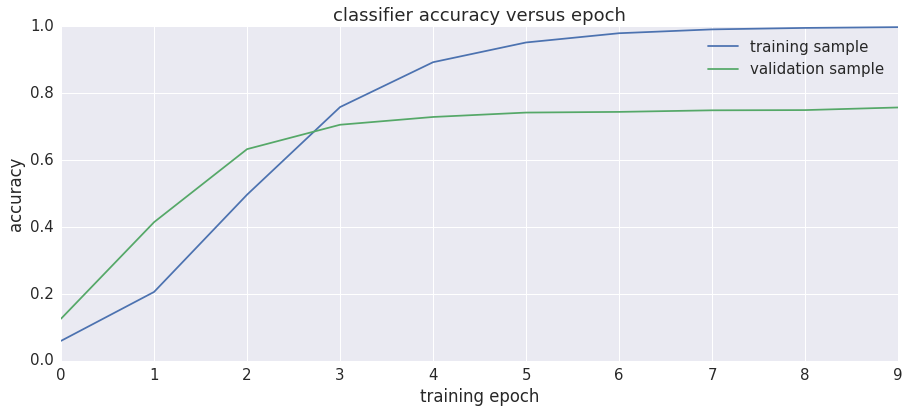

In [19]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['acc']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_acc']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier accuracy versus epoch')
ax.set_ylabel('accuracy')
ax.set_xlabel('training epoch')
ax_set_ylim(0.0, 1.05)
ax.legend()
plt.savefig('figs/accuracy.png')

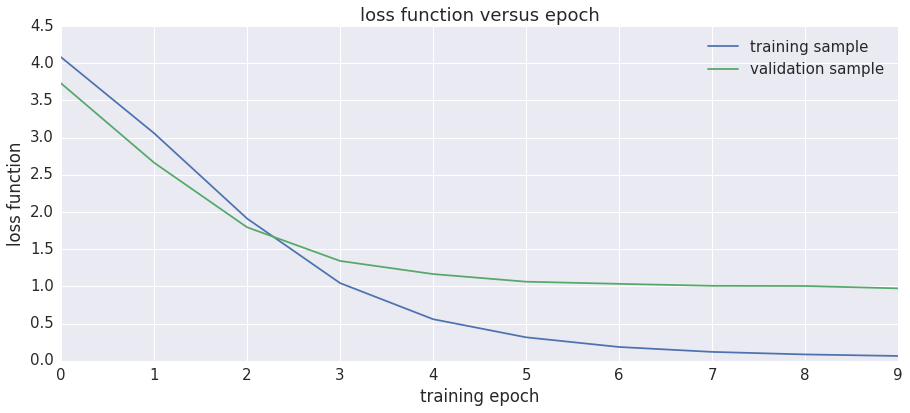

In [20]:
#plot loss function vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('loss function versus epoch')
ax.set_ylabel('loss function')
ax.set_xlabel('training epoch')
ax.legend()
plt.savefig('figs/loss.png')

In [21]:
#done!
print 'loss fn  = ', fit_history.history['loss'][-1]
print 'accuracy = ', fit_history.history['val_acc'][-1]
time_stop = time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

loss fn  =  0.0649556679641
accuracy =  0.756660134289
execution time (minutes) =  20.9681863983
